In [1]:
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from sklearn.cluster import KMeans
import random

import tensorflow as tf
import keras
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Conv2D, Activation, MaxPooling2D, Dense, Dropout, LeakyReLU, Conv2DTranspose, concatenate
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [2]:
### Load image
## Each image file consists of 2 parts, left one is Original image, Right one is labelled image 
## Image in (H,W,c)
train_path = "../input/cityscapes_data/cityscapes_data/train/"
val_path = "../input/cityscapes_data/cityscapes_data/val/"

train_list = glob.glob(train_path + "*.jp*")
val_list = glob.glob(val_path + "*.jp*")

def image_preprocessing(name, path):
    img = Image.open(path + name)
    
    img = np.array(img)
    # Seperate the segmentation and actual image
    seg = img[:,256:,:]
    img = img[:,0:256,:]
    
    # Improve the contrast of input image
    for i in range(3):
        c_img = cv2.equalizeHist(img[:,:,i])
        img[:,:,i] = c_img
        
    # Normalize image
    img = img/255
    seg = seg/255
    
    return (img, seg)

#a, b = image_preprocessing("1.jpg", train_path)

In [3]:
## In labelled images, there are many colours. So selecting  colors

colors = []
for i in range(1, 20):
    _, seg = image_preprocessing(str(i)+".jpg", train_path)
    seg = seg.reshape(seg.shape[0]*seg.shape[1], 3)
    colors.append(seg)
colors = np.array(colors)
colors = colors.reshape(colors.shape[0]*colors.shape[1], 3)

km = KMeans(13)
km.fit(colors)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=13, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [4]:
## These are 13 different classes
km.cluster_centers_

array([[0.79940255, 0.10317736, 0.25842119],
       [0.32752189, 0.04326869, 0.25010852],
       [0.50177786, 0.24733908, 0.49875926],
       [0.41943413, 0.55000842, 0.14415825],
       [0.93032203, 0.15578064, 0.88202059],
       [0.0218906 , 0.01636922, 0.02274004],
       [0.01801233, 0.02595343, 0.52517684],
       [0.62734255, 0.95642084, 0.61830582],
       [0.29392903, 0.49812277, 0.67855527],
       [0.47092786, 0.49860844, 0.39220702],
       [0.27595438, 0.27624175, 0.26982365],
       [0.75317909, 0.581827  , 0.64570919],
       [0.85120426, 0.79005258, 0.13650973]])

In [5]:
## Convert the segmented output (H, W, n_classes) to original RGB format (H, W, 3) for visualization
## This uses unique clusters created by KMeans so original colours are repeated.

def layers_to_rgb(seg, kmcolors = km.cluster_centers_):
    """Converts (H,W, n_class) image to (H, W, 3)
        inputs:
            numpy array : img(H, W, n_class)
            kmeans cluster centers: 
        
        output:
            numpy array : nimg(H, W, 3)
    """
    
    seg = np.argmax(seg, axis = -1)
    h, w = seg.shape
    
    seg = seg.reshape(h*w)
    
    final_seg = []
    
    for i in range(h*w):
        col = kmcolors[seg[i]]
        final_seg.append(col)
        
    final_seg = np.array(final_seg)
    final_seg = final_seg.reshape(h, w, 3)
    
    return final_seg

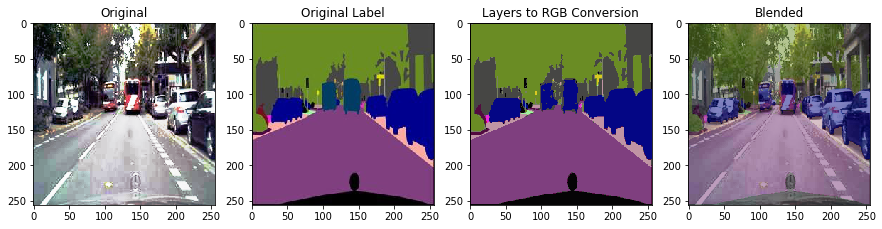

In [6]:
# Convert the segmentation images to 13 different classes
# Intuituly the image is (H, W, n_class) where each pixel is 1 hot encoding
def colors_to_class(seg):
    s = seg.reshape((seg.shape[0]*seg.shape[1],3))
    s = km.predict(s)
    s = s.reshape((seg.shape[0], seg.shape[1]))
    
    ## s now is (H, W) sized array, each value is a number between (0-12) indicating class of colour
    
    # find out num of classes, 13 here
    n = len(km.cluster_centers_)
    
    # Create a (H, W, n) sized zeros array (n channels). To each channel, put 1 & 0 corresponding to
    # presence of object
    seg_cls = np.zeros((seg.shape[0], seg.shape[1], n))
    
    for i in range(n):
        tmp_chl = np.copy(s)
        tmp_chl[tmp_chl != i] = 0
        tmp_chl[tmp_chl != 0] = 1
        
        seg_cls[:,:,i] = tmp_chl
        
    return seg_cls

img, seg = image_preprocessing("29.jpg", train_path)
seg2 = colors_to_class(seg)
seg2 = layers_to_rgb(seg2)

# To blend 2 images
blended = cv2.addWeighted(img, 0.5, seg2, 0.5, 0)
#plt.imshow(blended)
#plt.show()

plots = [img, seg, seg2, blended]
plots_titles = ["Original", "Original Label", "Layers to RGB Conversion", "Blended"]
plt.figure(figsize=(15, 15))

for i in range(4):
    plt.subplot(1,4,i+1)
    plt.title(plots_titles[i])
    plt.imshow(plots[i])

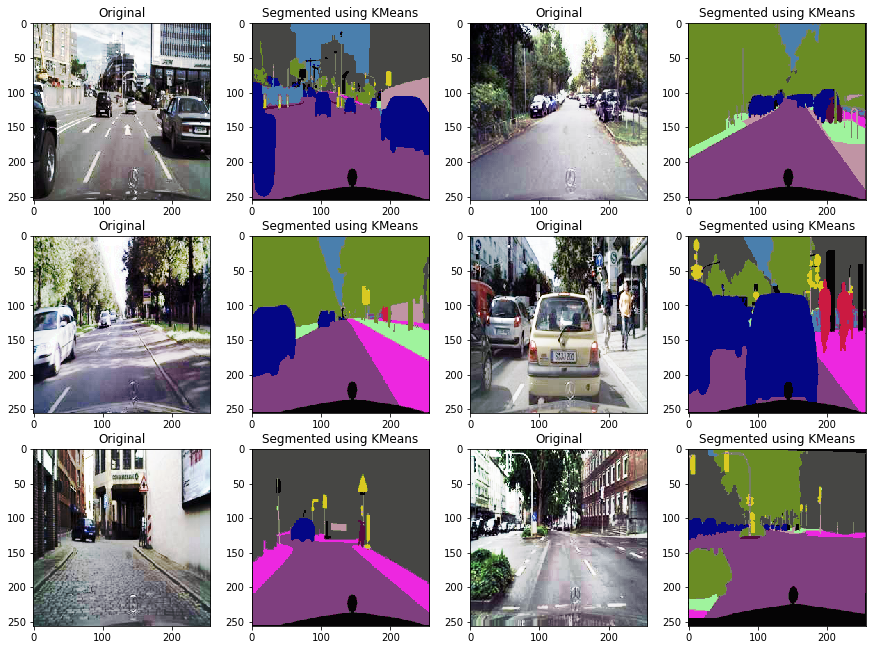

In [7]:
## Data Generator
def data_generator(train_list = train_list, path = train_path, batch_size=12):
    
    while True:
        batch_imgs = []
        batch_segs = []
        
        for i in range(batch_size):
            img_path = random.sample(train_list, 1)[0]
            
            img_name = img_path.split("/")[-1]
            
            img, seg = image_preprocessing(img_name, train_path)
            
            seg = colors_to_class(seg)
            
            batch_imgs.append(img)
            batch_segs.append(seg)
        yield np.array(batch_imgs), np.array(batch_segs)
        
gen = data_generator(train_list)
batch_imgs, batch_segs = next(gen)

plt.figure(figsize = (15,15))
for i in range(12):
    plt.subplot(4, 4, i + 1)
    if (i+1) % 2 == 1:
        plt.title("Original")
        plt.imshow(batch_imgs[i])
    else:
        plt.title("Segmented using KMeans")
        plt.imshow(layers_to_rgb(batch_segs[i - 1]))

In [8]:
## Unet from VGG16
## take jump connections before maxpool

base_model = keras.applications.VGG16(include_top=False,input_shape = (256, 256, 3), weights="imagenet")

base_model.trainable = False
    
base_model.summary()
    
i1 = base_model.get_layer('block1_conv2').output
i2 = base_model.get_layer('block2_conv2').output
i3 = base_model.get_layer('block3_conv3').output
i4 = base_model.get_layer('block4_conv3').output
i5 = base_model.get_layer('block5_conv3').output

58892288/58889256 [==============================] - 2s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool

In [9]:
i6 = Conv2DTranspose(filters = 512, kernel_size = (2, 2), strides = 2, padding = "same")(i5)
i6 = concatenate([i6, i4])
i6 = Conv2D(filters = 512, kernel_size = (3, 3), padding = "same")(i6)
i6 = BatchNormalization()(i6)
i6 = Activation("relu")(i6)
i6 = Conv2D(filters = 512, kernel_size = (3, 3), padding = "same")(i6)
i6 = BatchNormalization()(i6)
i7 = Activation("relu")(i6)

i7 = Conv2DTranspose(filters = 256, kernel_size = (2, 2), strides = 2, padding = "same")(i7)
i7 = concatenate([i7, i3])
i7 = Conv2D(filters = 256, kernel_size = (3, 3), padding = "same")(i7)
i7 = BatchNormalization()(i7)
i7 = Activation("relu")(i7)
i7 = Conv2D(filters = 256, kernel_size = (3, 3), padding = "same")(i7)
i7 = BatchNormalization()(i7)
i8 = Activation("relu")(i7)

i8 = Conv2DTranspose(filters = 128, kernel_size = (2, 2), strides = 2, padding = "same")(i8)
i8 = concatenate([i8, i2])
i8 = Conv2D(filters = 128, kernel_size = (3, 3), padding = "same")(i8)
i8 = BatchNormalization()(i8)
i8 = Activation("relu")(i8)
i8 = Conv2D(filters = 128, kernel_size = (3, 3), padding = "same")(i8)
i8 = BatchNormalization()(i8)
i9 = Activation("relu")(i8)

i9 = Conv2DTranspose(filters = 64, kernel_size = (2, 2), strides = 2, padding = "same")(i9)
i9 = concatenate([i9, i1])
i9 = Conv2D(filters = 64, kernel_size = (3, 3), padding = "same")(i9)
i9 = BatchNormalization()(i9)
i9 = Activation("relu")(i9)
i9 = Conv2D(filters = 64, kernel_size = (3, 3), padding = "same")(i9)
i9 = BatchNormalization()(i9)
i10 = Activation("relu")(i9)

In [10]:
i11 = Conv2D(13, 6, activation="softmax", padding="same")(i10)

In [11]:
model = Model(inputs = [base_model.input], outputs = [i11], name = "VGG16_Unet")

In [12]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 256, 256, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 128, 128, 64) 0           block1_conv2[0][0]               
__________________________________________________________________________________________________
block2_con

In [13]:
model.compile(optimizer = Adam(), loss="categorical_crossentropy", metrics=["accuracy"])

In [14]:
train_gen = data_generator(train_list, batch_size = 35)
val_gen = data_generator(val_list, batch_size = 25)

clb = [ModelCheckpoint("loss.h5", save_best_only = True, verbose = 1)]

In [15]:
h = model.fit_generator(train_gen, epochs = 125, steps_per_epoch = 85,
                       validation_data = val_gen, validation_steps = 20,
                       callbacks=clb, verbose = 1)

Epoch 1/125
85/85 [==============================] - 143s 2s/step - loss: 0.9095 - acc: 0.7160 - val_loss: 1.2684 - val_acc: 0.6545

Epoch 00001: val_loss improved from inf to 1.26837, saving model to loss.h5
Epoch 2/125
85/85 [==============================] - 125s 1s/step - loss: 0.6308 - acc: 0.8002 - val_loss: 0.9072 - val_acc: 0.7509

Epoch 00002: val_loss improved from 1.26837 to 0.90720, saving model to loss.h5
Epoch 3/125
85/85 [==============================] - 125s 1s/step - loss: 0.5814 - acc: 0.8141 - val_loss: 0.6083 - val_acc: 0.8167

Epoch 00003: val_loss improved from 0.90720 to 0.60832, saving model to loss.h5
Epoch 4/125
85/85 [==============================] - 123s 1s/step - loss: 0.5445 - acc: 0.8239 - val_loss: 0.6274 - val_acc: 0.8096

Epoch 00004: val_loss did not improve from 0.60832
Epoch 5/125
85/85 [==============================] - 124s 1s/step - loss: 0.5204 - acc: 0.8298 - val_loss: 0.5260 - val_acc: 0.8347

Epoch 00005: val_loss improved from 0.60832 to 0

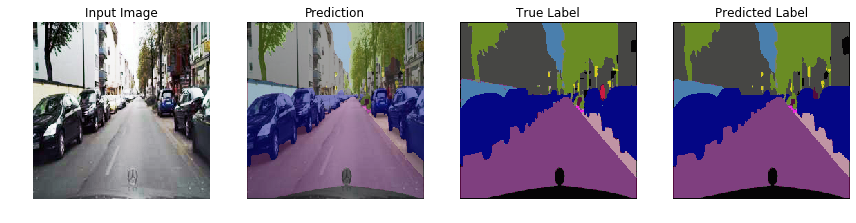

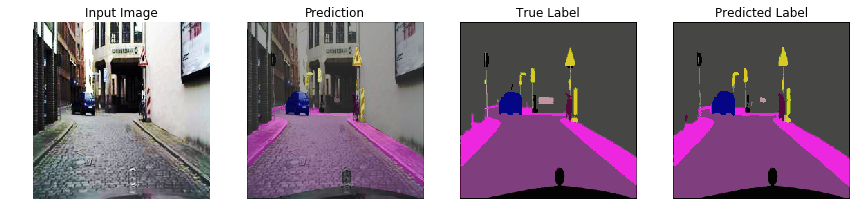

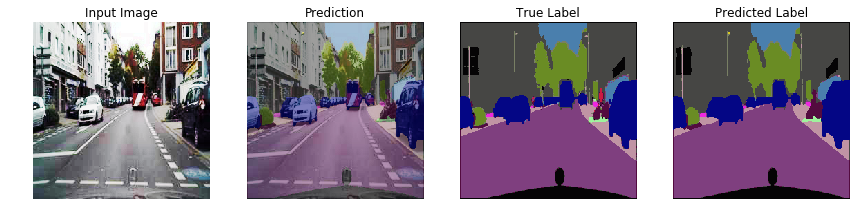

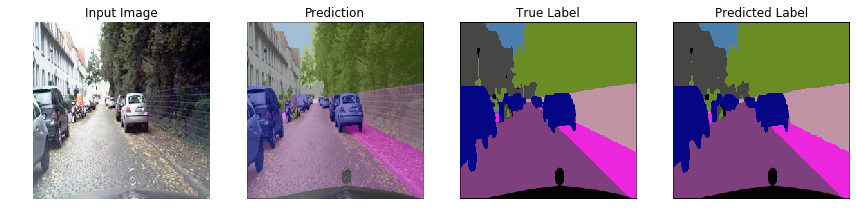

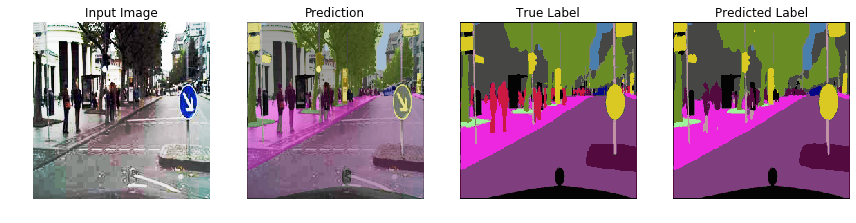

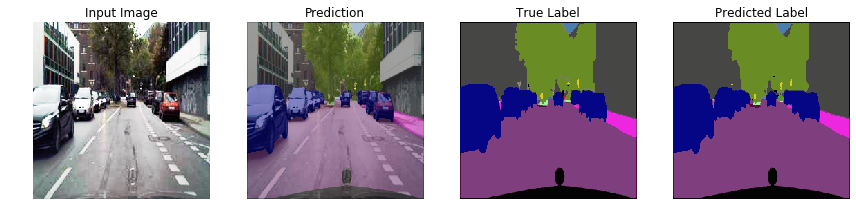

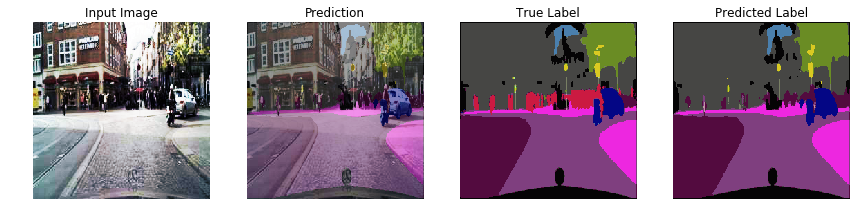

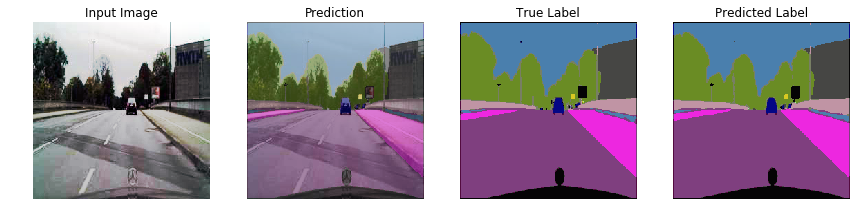

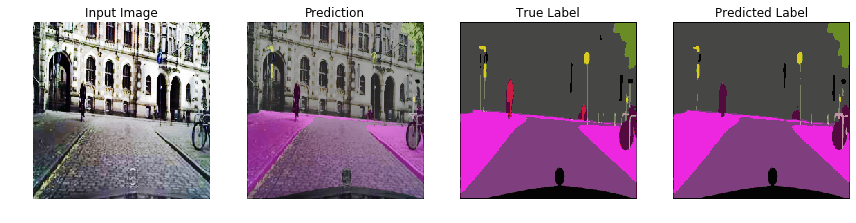

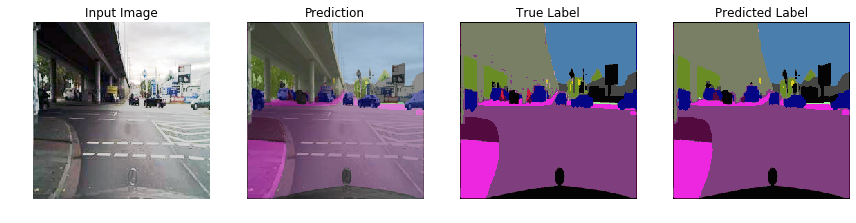

In [16]:
test_gen = data_generator(val_list, batch_size = 10)
max_show = 20
for imgs, segs in test_gen:
    p = model.predict(imgs)
    for i in range(p.shape[0]):
        if i > max_show:
            break
        _p = layers_to_rgb(p[i])
        _s = layers_to_rgb(segs[i])
        
        predimg = cv2.addWeighted(imgs[i], 0.5, _p, 0.5, 0)
        trueimg = cv2.addWeighted(imgs[i], 0.0, _s, 1, 0)
        plt.figure(figsize=(12,6))
        plt.subplot(141)
        plt.title("Input Image")
        plt.imshow(imgs[i])
        plt.axis("off")
        plt.subplot(142)
        plt.title("Prediction")
        plt.imshow(predimg)
        plt.axis("off")
        plt.subplot(143)
        plt.title("True Label")
        plt.imshow(_s)
        plt.axis("off")
        plt.subplot(144)
        plt.title("Predicted Label")
        plt.imshow(_p)
        plt.axis("off")
        
        plt.tight_layout()
        plt.savefig("pred_"+str(i)+".png", dpi=150)
        plt.show()
    break